In [1]:
from google.colab import drive
drive.mount("MyDrive")
%cd "MyDrive/MyDrive/NLP/Project"

Mounted at MyDrive
/content/MyDrive/MyDrive/NLP/Project


In [ ]:
! ls

 2005.06557v2.pdf      'NLP Final Task.rar'			      text_and_dialect.csv
 dialects_database.db  'NLP_Project(1)_DataFetch.ipynb'		      voting_pipeline.pkl
 hist.csv	       'NLP_Project(2)_EDA_DataPreprocessing.ipynb'
'NLP Final Task.pdf'    pipeline.pkl


In [2]:
! pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm import tqdm
import emoji
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, TimeDistributed, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow_addons.metrics import F1Score
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to C:\Users\LAPTOP
[nltk_data]     SHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Versions of libraries used :

In [ ]:
print("numpy version  : ",np.__version__)
print("pandas version  : ",pd.__version__)
print("re version  : ",re.__version__)
print("scikit-learn  : ",sklearn.__version__)
print("nltk version  : ",nltk.__version__)
print("emoji version  : ",emoji.__version__)
print("tensorflow version  : ",tf.__version__)


numpy version  :  1.25.2
pandas version  :  2.0.3
re version  :  2.2.1
scikit-learn  :  1.2.2
nltk version  :  3.8.1
emoji version  :  2.12.1
tensorflow version  :  2.15.0


# Reading Data and pre-processing

In [2]:
df = pd.read_csv('text_and_dialect.csv', encoding='utf-8', engine='python')
df.dropna(inplace=True)
X_train, X_other, y_train, y_other = train_test_split(df['text'], df['dialect'], test_size=0.2, shuffle=True, stratify=df['dialect'], random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, shuffle=True, stratify=y_other, random_state=123)
train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [3]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords_arabic = set(stopwords.words('arabic'))

    def fit(self, X, y=None):
        # Add code for fitting the transformer here
        return self

    def transform(self, X):
        transformed_X = X.copy()
        transformed_X = X.apply(self.clean_txt)
        return transformed_X

    def clean_txt(self, text):
        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

        # Remove usernames starting with @
        text = re.sub(r'@[\w_]+', ' ', text)

        # Remove English words
        text = re.sub(r'\b[a-zA-Z]+\b', ' ', text)

        # Remove emojis
        text = re.sub(r'[\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r':[a-z_]+:', ' ', text)

        # Remove special characters
        text = re.sub('[*?!#@]', ' ', text)

        # Remove redundant percentage and bar lines
        text = re.sub(r'\|\|+\s*\d+%\s*\|\|+?[_\-\.\?]+', ' ', text)

        text = re.sub(r'[_\-\.\"\:\;\,\'\،\♡\\\)/(\&\؟]', ' ', text)

        # Remove digits
        text = re.sub(r'\d+', ' ', text)

        text_tokens = text.split()

        # filtered_text = [word for word in text_tokens if word not in self.stopwords_arabic]
        filtered_text = text_tokens
        # Split and rejoin
        text = ' '.join(filtered_text)

        return text

    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        self.fit(X, y)
        return self.transform(X)

## ========================= Machine Learning model part ===========================

# Base model Training :

In [ ]:
model = LogisticRegression(max_iter=10000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
count_vectorizer = CountVectorizer(max_features=5000)

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', count_vectorizer),
    ('model', model),
])

In [ ]:
X_train = train["text"]
y_train = train["dialect"]

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', CountVectorizer(max_features=5000)),
                ('model', LogisticRegression(max_iter=10000))])

# Base model results :

In [ ]:
y_pred = pipeline.predict(X_val)

In [ ]:
report = classification_report(y_val, y_pred)

print(report)

              precision    recall  f1-score   support

          EG       0.82      0.88      0.85      5763
          LB       0.83      0.80      0.81      2761
          LY       0.73      0.79      0.76      3650
          MA       0.81      0.64      0.71      1154
          SD       0.78      0.57      0.66      1444

    accuracy                           0.80     14772
   macro avg       0.79      0.74      0.76     14772
weighted avg       0.80      0.80      0.79     14772



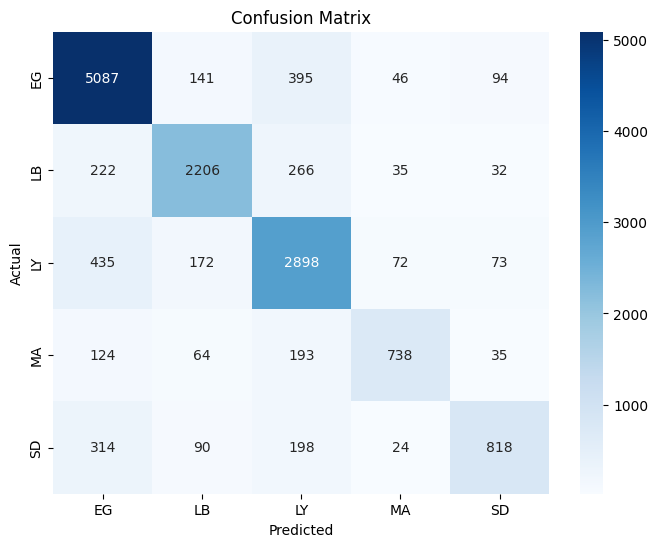

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

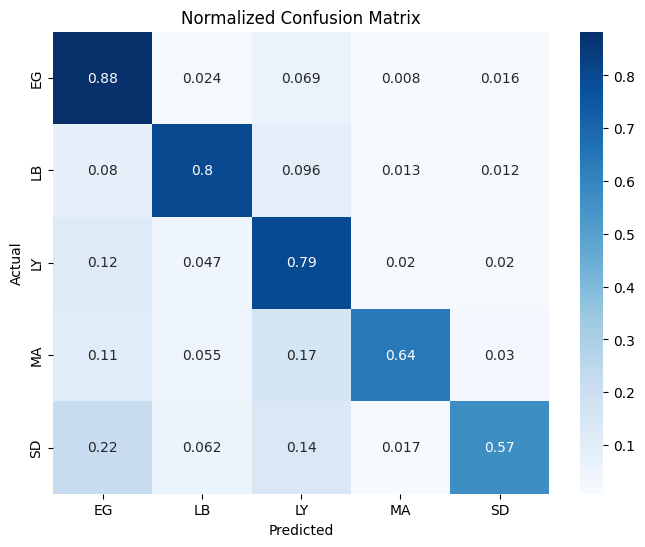

In [ ]:
normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# `Optimize Model By Optuna .. `

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import f1_score, make_scorer

def objective(trial):
    vectorizer_type = trial.suggest_categorical('vectorizer', ['count', 'tfidf'])
    max_features = trial.suggest_int('max_features', 1000, 20000)
    C = trial.suggest_float('C', 1, 1000, log=True)

    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(max_features=max_features)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features)

    model = LogisticRegression(max_iter=10000, C=C)

    pipeline = Pipeline(steps=[
        ('preprocessing', CustomTransformer()),
        ('Vectorizing', vectorizer),
        ('model', model),
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    f1_macro = f1_score(y_val, y_pred, average='macro')

    return f1_macro

f1_scorer = make_scorer(f1_score, average='macro')

study = optuna.create_study(direction='maximize', study_name='Optimizing_My_Model', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_C = best_params['C']
best_max_features = best_params['max_features']
best_vectorizer_type = best_params['vectorizer']

if best_vectorizer_type == 'count':
    best_vectorizer = CountVectorizer(max_features=best_max_features)
else:
    best_vectorizer = TfidfVectorizer(max_features=best_max_features)

print("Best parameters:", best_params)

[I 2024-05-25 16:42:40,790] A new study created in memory with name: Optimizing_My_Model
[I 2024-05-25 16:45:43,781] Trial 0 finished with value: 0.7525961162037488 and parameters: {'vectorizer': 'tfidf', 'max_features': 14908, 'C': 62.51373574521747}. Best is trial 0 with value: 0.7525961162037488.
[I 2024-05-25 16:47:47,970] Trial 1 finished with value: 0.718725950527262 and parameters: {'vectorizer': 'count', 'max_features': 2103, 'C': 396.7605077052986}. Best is trial 0 with value: 0.7525961162037488.
[I 2024-05-25 16:48:53,849] Trial 2 finished with value: 0.7032878739301253 and parameters: {'vectorizer': 'tfidf', 'max_features': 1391, 'C': 812.3245085588683}. Best is trial 0 with value: 0.7525961162037488.
[I 2024-05-25 16:49:50,499] Trial 3 finished with value: 0.7516906618740059 and parameters: {'vectorizer': 'count', 'max_features': 4454, 'C': 3.5498788321965016}. Best is trial 0 with value: 0.7525961162037488.
[I 2024-05-25 16:51:08,934] Trial 4 finished with value: 0.7693382

Best parameters: {'vectorizer': 'tfidf', 'max_features': 19833, 'C': 3.008513074950468}


In [ ]:
print(f"The best trial is : \n{study.best_trial}")
print()
print(f"The best value is : \n{study.best_value}")
print()
print(f"The best parameters are : \n{study.best_params}")


The best trial is : 
FrozenTrial(number=15, state=TrialState.COMPLETE, values=[0.792676888741709], datetime_start=datetime.datetime(2024, 5, 25, 17, 6, 36, 910272), datetime_complete=datetime.datetime(2024, 5, 25, 17, 7, 50, 316761), params={'vectorizer': 'tfidf', 'max_features': 19833, 'C': 3.008513074950468}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vectorizer': CategoricalDistribution(choices=('count', 'tfidf')), 'max_features': IntDistribution(high=20000, log=False, low=1000, step=1), 'C': FloatDistribution(high=1000.0, log=True, low=1.0, step=None)}, trial_id=15, value=None)

The best value is : 
0.792676888741709

The best parameters are : 
{'vectorizer': 'tfidf', 'max_features': 19833, 'C': 3.008513074950468}


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=['vectorizer', 'max_features', "C"])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
history_csv = study.trials_dataframe()
history_csv.to_csv("hist.csv")
history_csv

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_features,params_vectorizer,state
0,0,0.752596,2024-05-25 16:42:40.796525,2024-05-25 16:45:43.780851,0 days 00:03:02.984326,62.513736,14908,tfidf,COMPLETE
1,1,0.718726,2024-05-25 16:45:43.782716,2024-05-25 16:47:47.970373,0 days 00:02:04.187657,396.760508,2103,count,COMPLETE
2,2,0.703288,2024-05-25 16:47:47.973086,2024-05-25 16:48:53.849431,0 days 00:01:05.876345,812.324509,1391,tfidf,COMPLETE
3,3,0.751691,2024-05-25 16:48:53.852034,2024-05-25 16:49:50.499474,0 days 00:00:56.647440,3.549879,4454,count,COMPLETE
4,4,0.769338,2024-05-25 16:49:50.501610,2024-05-25 16:51:08.934612,0 days 00:01:18.433002,7.476312,9207,tfidf,COMPLETE
5,5,0.751803,2024-05-25 16:51:08.936787,2024-05-25 16:52:38.718058,0 days 00:01:29.781271,12.562774,6551,count,COMPLETE
6,6,0.752367,2024-05-25 16:52:38.720081,2024-05-25 16:54:23.890779,0 days 00:01:45.170698,34.890188,4794,tfidf,COMPLETE
7,7,0.768000,2024-05-25 16:54:23.892729,2024-05-25 16:55:31.174374,0 days 00:01:07.281645,3.247674,12543,count,COMPLETE
8,8,0.730845,2024-05-25 16:55:31.176251,2024-05-25 17:00:31.197437,0 days 00:05:00.021186,266.190189,19347,tfidf,COMPLETE
9,9,0.749214,2024-05-25 17:00:31.202779,2024-05-25 17:02:39.712315,0 days 00:02:08.509536,20.914981,14001,count,COMPLETE


# Training Best model obtained :

In [ ]:
model = LogisticRegression(max_iter=10000, C=3)
tfidf_vectorizer = TfidfVectorizer(max_features=19900)

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', tfidf_vectorizer),
    ('model', model),
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', TfidfVectorizer(max_features=19900)),
                ('model', LogisticRegression(C=3, max_iter=10000))])

# See Results on test sample :

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

          EG       0.84      0.91      0.87      5764
          LB       0.85      0.84      0.85      2762
          LY       0.78      0.81      0.79      3650
          MA       0.84      0.66      0.74      1154
          SD       0.80      0.61      0.69      1443

    accuracy                           0.82     14773
   macro avg       0.82      0.77      0.79     14773
weighted avg       0.82      0.82      0.82     14773



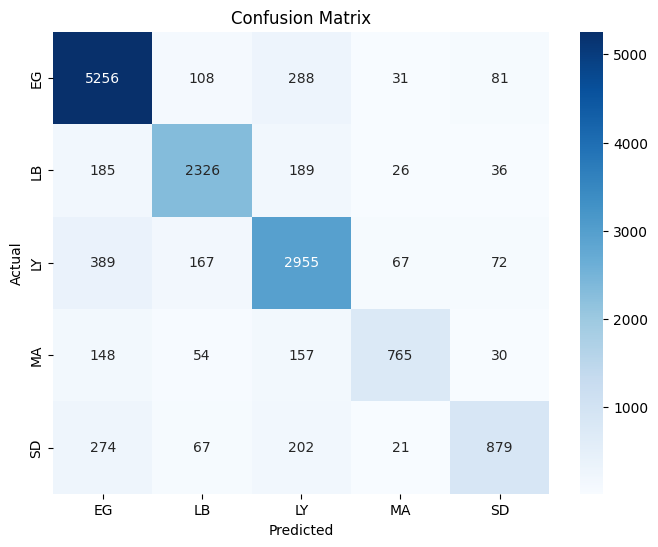

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

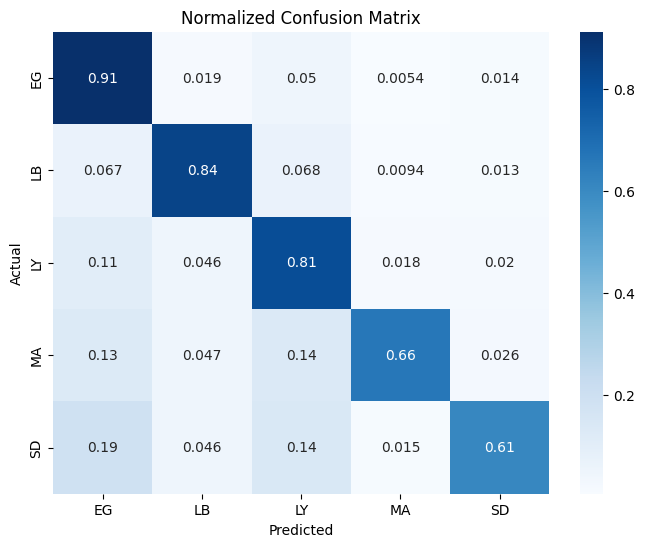

In [ ]:
normalized_cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Saving Whole pipeline :

In [ ]:
import joblib

joblib.dump(pipeline, 'pipeline.pkl')

# Load it to check it is properly saved ✅
loaded_pipeline = joblib.load('pipeline.pkl')



## ========================= Deep Learning model part ===========================

In [ ]:
def clean_txt(text):
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove usernames starting with @
    text = re.sub(r'@[\w_]+', ' ', text)

    # Remove English words
    text = re.sub(r'\b[a-zA-Z]+\b', ' ', text)

    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', ' ', text)
    text = re.sub(r':[a-z_]+:', ' ', text)

    # Remove special characters
    text = re.sub('[*?!#@]', ' ', text)

    # Remove redundant percentage and bar lines
    text = re.sub(r'\|\|+\s*\d+%\s*\|\|+?[_\-\.\?]+', ' ', text)

    text = re.sub(r'[_\-\.\"\:\;\,\'\،\♡\\\)/(\&\؟]', ' ', text)

    # Remove digits
    text = re.sub(r'\d+', ' ', text)

    text_tokens = text.split()

    # filtered_text = [word for word in text_tokens if word not in self.stopwords_arabic]
    filtered_text = text_tokens
    # Split and rejoin
    text = ' '.join(filtered_text)

    return text

In [ ]:
train['clean_text'] = train['text'].apply(clean_txt)
val['clean_text'] = val['text'].apply(clean_txt)
test['clean_text'] = test['text'].apply(clean_txt)

In [ ]:
train.head(10)

,text,dialect,clean_text
0,- معايا مناسبة عايز اروحها \n\nحباية فى وشى * https://t.co/boy2wXLQo6,EG,معايا مناسبة عايز اروحها حباية فى وشى
1,@Rooka25 مش انتى كاتبه بتيسطروا ازاى \nب ٣ حاجات دى,EG,مش انتى كاتبه بتيسطروا ازاى ب حاجات دى
2,@eslamalmgrbe الف لا لاس عليها وربي يشفيها ويطول عمرها,LY,الف لا لاس عليها وربي يشفيها ويطول عمرها
3,@Dalia_PT ده بيبقى سلام بارد ومؤقت وخصوصآ لما بيبقى بينهم أولاد,EG,ده بيبقى سلام بارد ومؤقت وخصوصآ لما بيبقى بينهم أولاد
4,@A_Almahmoudy بيت شعر مش حكمة يا حكيه 😂,LY,بيت شعر مش حكمة يا حكيه
5,@monmon_29__ @EveElmasry @Tempest297 المهم انهم محرمين انها تتعرى بمزاجها انما واحد يعريها زي البقرة غصب عنها عشان يشتريها فده حلال وفل الفل,EG,المهم انهم محرمين انها تتعرى بمزاجها انما واحد يعريها زي البقرة غصب عنها عشان يشتريها فده حلال وفل الفل
6,@Dr_Wessam ده فطار مفتخر بقى .. الحقني بيه,EG,ده فطار مفتخر بقى الحقني بيه
7,"في 2005 تخرجت من الهندسة وتعرضت لنفس الوضع, طبعا هو موضوع متأصل خاصة في طلبة السكن الجامعي اللي مكونين ما يشبه الاخوية وليها قوانين خاصة لا يمكنك الاعتراض عليها. وعموما لما يكون جمهور متخرجين او حتى دكاترة فان افعالهم لا تمتل الاراء الفردية وتعامل ككتلة متحركة صعب التكهن بافعالها https://t.co/80461Q6JI8",LY,في تخرجت من الهندسة وتعرضت لنفس الوضع طبعا هو موضوع متأصل خاصة في طلبة السكن الجامعي اللي مكونين ما يشبه الاخوية وليها قوانين خاصة لا يمكنك الاعتراض عليها وعموما لما يكون جمهور متخرجين او حتى دكاترة فان افعالهم لا تمتل الاراء الفردية وتعامل ككتلة متحركة صعب التكهن بافعالها
8,#شفيق_باع_نفسه_للجزيرة\nشفيق على قنوات الإخوان طلع مظلووم ومهدور حقه \nوبيقولوا هنقف جنبه لأننا مظلومين زي بعض \nآخر نكته 😂😂😂😂,EG,شفيق باع نفسه للجزيرة شفيق على قنوات الإخوان طلع مظلووم ومهدور حقه وبيقولوا هنقف جنبه لأننا مظلومين زي بعض آخر نكته
9,@Dr_rame7 صدق الاثنين الاثنين صح .,EG,صدق الاثنين الاثنين صح


In [ ]:
def get_longest_text(texts):
  longest_input = 0
  for text in texts:
      text_len= len(text.split())
      longest_input = max(longest_input, text_len)
  return longest_input

print(get_longest_text(train['clean_text']))

65


# Create Tokenizer :

In [ ]:
max_seq_len = 40

# Only use train data !!
tokenizer = Tokenizer(num_words=max_seq_len)
tokenizer.fit_on_texts(train['clean_text'])
word_to_idx = tokenizer.word_index

In [ ]:
word_to_idx

{'من': 1,
 'في': 2,
 'ما': 3,
 'و': 4,
 'مش': 5,
 'اللي': 6,
 'يا': 7,
 'بس': 8,
 'على': 9,
 'انا': 10,
 'الله': 11,
 'كل': 12,
 'ده': 13,
 'ولا': 14,
 'لو': 15,
 'علي': 16,
 'لا': 17,
 'كان': 18,
 'انت': 19,
 'والله': 20,
 'هو': 21,
 'دي': 22,
 'مع': 23,
 'ان': 24,
 'ايه': 25,
 'الناس': 26,
 'فى': 27,
 'شي': 28,
 'عشان': 29,
 'لما': 30,
 'فيه': 31,
 'غير': 32,
 'ف': 33,
 'ع': 34,
 'عن': 35,
 'واحد': 36,
 'حد': 37,
 'يعني': 38,
 'او': 39,
 'مصر': 40,
 'عم': 41,
 'كده': 42,
 'فيها': 43,
 'اللى': 44,
 'بعد': 45,
 'زي': 46,
 'دا': 47,
 'ربنا': 48,
 'حتى': 49,
 'ليه': 50,
 'اي': 51,
 'احنا': 52,
 'لكن': 53,
 'لي': 54,
 'ناس': 55,
 'مين': 56,
 'شو': 57,
 'حاجة': 58,
 'ممكن': 59,
 'عليه': 60,
 'يوم': 61,
 'كتير': 62,
 'لازم': 63,
 'عليك': 64,
 'هي': 65,
 'يارب': 66,
 'قبل': 67,
 'كنت': 68,
 'كمان': 69,
 'كيف': 70,
 'أنا': 71,
 'انه': 72,
 'الي': 73,
 'حاجه': 74,
 'انو': 75,
 'هذا': 76,
 'وين': 77,
 'ربي': 78,
 'اذا': 79,
 'علشان': 80,
 'عارف': 81,
 'الا': 82,
 'يلي': 83,
 'طيب': 84,
 'بقى': 

## Most frequent words :

In [ ]:
# Get the top 20 most frequent words
word_counts = tokenizer.word_counts
top_n = 20
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

print("Top", top_n, "most frequent words:")
for word, freq in top_words:
    print(word, "-", freq)

Top 20 most frequent words:
من - 24656
في - 22847
ما - 17676
و - 17378
مش - 15030
اللي - 14704
يا - 14216
بس - 12194
على - 9955
انا - 9275
الله - 8916
كل - 7930
ده - 7902
ولا - 7184
لو - 5500
علي - 5475
لا - 5408
كان - 5251
انت - 5227
والله - 5212


## `I can't Drop them because most of them are representing dialect !! `

In [ ]:
print(f"Corpus have number of unique wors is : {len(word_to_idx)} word")

Corpus have number of unique wors is : 216049 word


# Padding :

In [ ]:
def process_sentence(sentence, tokenizer):
    word_to_idx = tokenizer.word_index
    X_tokens = tokenizer.texts_to_sequences([sentence])
    X_tokens_pad = pad_sequences(X_tokens, maxlen=max_seq_len, padding='post')
    return X_tokens_pad

def padding_vectors(df):
    num_sentences = len(df['clean_text'])
    X_tokens_pad_array = np.zeros((num_sentences, max_seq_len), dtype=int)

    for i, sentence in enumerate(df['clean_text']):
        X_tokens_pad = process_sentence(sentence, tokenizer)
        X_tokens_pad_array[i, :] = X_tokens_pad
    return X_tokens_pad_array

In [ ]:
train_seq_pad = padding_vectors(train)
val_seq_pad = padding_vectors(val)
test_seq_pad = padding_vectors(test)


In [ ]:
print(train_seq_pad.shape)
print(val_seq_pad.shape)
print(test_seq_pad.shape)

(118180, 40)
(14772, 40)
(14773, 40)


# OHE to labels for modeling :

In [ ]:
y_train = train['dialect']
y_val = val['dialect']
y_test = test['dialect']

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
classes = 5
y_train_categorical = to_categorical(y_train_encoded, num_classes=classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=classes)

In [ ]:
print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)

(118180, 5)
(14772, 5)
(14773, 5)


In [ ]:
def categorical_crossentropy_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def build_rnn_model(input_dim, output_dim, input_length, rnn_units=128, network=SimpleRNN):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        network(rnn_units, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',\
                                                                              tf.metrics.F1Score(average='macro')\
                                                                              ,categorical_crossentropy_loss])
    # model.summary()
    return model

In [ ]:
def build_rnn_model_2(input_dim, output_dim, input_length, rnn_units=128, network=SimpleRNN):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        network(rnn_units, return_sequences=False),
        Dense(128, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    return model

# Building Base model :

In [ ]:
input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
output_dim = 32   # Embedding dimension
rnn_units = 32    # Number of RNN units

model = build_rnn_model(input_dim, output_dim, input_length=None, rnn_units=rnn_units, network=SimpleRNN)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          6913600   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 128)               4224      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                                 
Total params: 6928485 (26.43 MB)
Trainable params: 6928485 (26.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(train_seq_pad.shape)
print(y_train_categorical.shape)

print(val_seq_pad.shape)
print(y_val_categorical.shape)


(118180, 40)
(118180, 5)
(14772, 40)
(14772, 5)


In [ ]:
history = model.fit(train_seq_pad, y_train_categorical, epochs=10, batch_size=128, validation_data=(val_seq_pad, y_val_categorical), validation_steps=1)

Epoch 1/10
924/924 [==============================] - 46s 47ms/step - loss: 1.4091 - accuracy: 0.4031 - f1_score: 0.1920 - categorical_crossentropy_loss: 1.4091 - val_loss: 1.3559 - val_accuracy: 0.4297 - val_f1_score: 0.2708 - val_categorical_crossentropy_loss: 1.3559
Epoch 2/10
924/924 [==============================] - 43s 47ms/step - loss: 1.3184 - accuracy: 0.4313 - f1_score: 0.2616 - categorical_crossentropy_loss: 1.3184 - val_loss: 1.2717 - val_accuracy: 0.4844 - val_f1_score: 0.3209 - val_categorical_crossentropy_loss: 1.2717
Epoch 3/10
924/924 [==============================] - 42s 46ms/step - loss: 1.2873 - accuracy: 0.4450 - f1_score: 0.2943 - categorical_crossentropy_loss: 1.2873 - val_loss: 1.2246 - val_accuracy: 0.5000 - val_f1_score: 0.3174 - val_categorical_crossentropy_loss: 1.2246
Epoch 4/10
924/924 [==============================] - 39s 42ms/step - loss: 1.2744 - accuracy: 0.4489 - f1_score: 0.3070 - categorical_crossentropy_loss: 1.2744 - val_loss: 1.2372 - val_accu

# Model Optimization :

In [ ]:
import optuna
def objective(trial):
    output_dim = trial.suggest_categorical('output_dim', [16, 32, 64, 128])
    network_type = trial.suggest_categorical('Network', ['SimpleRNN', 'GRU', 'LSTM'])
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])

    if network_type == 'SimpleRNN':
        Network = SimpleRNN
    elif network_type == 'GRU':
        Network = GRU
    else:
        Network = LSTM

    model = build_rnn_model(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=None,
                            network=Network)

    history = model.fit(train_seq_pad, y_train_categorical,
                        epochs=10,
                        batch_size=batch_size,
                        validation_data=(val_seq_pad, y_val_categorical),
                        validation_steps=1,
                        verbose=1)

    val_pred = model.predict(val_seq_pad)
    val_f1 = f1_score(np.argmax(y_val_categorical, axis=1), np.argmax(val_pred, axis=1), average='macro')

    return val_f1

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)


[I 2024-05-25 20:00:51,977] A new study created in memory with name: no-name-b2eb3875-e06c-4a8e-99ff-46479be9eba6


Epoch 1/10
924/924 [==============================] - 13s 11ms/step - loss: 1.4548 - accuracy: 0.3901 - f1_score: 0.1182 - categorical_crossentropy_loss: 1.4548 - val_loss: 1.4166 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4166
Epoch 2/10
924/924 [==============================] - 9s 10ms/step - loss: 1.4540 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4540 - val_loss: 1.4160 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4160
Epoch 3/10
924/924 [==============================] - 9s 10ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4121 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4121
Epoch 4/10
924/924 [==============================] - 9s 10ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4194 - val_accurac

[I 2024-05-25 20:03:19,013] Trial 0 finished with value: 0.11225712198685171 and parameters: {'output_dim': 64, 'Network': 'LSTM', 'batch_size': 128}. Best is trial 0 with value: 0.11225712198685171.


Epoch 1/10
462/462 [==============================] - 26s 51ms/step - loss: 1.4198 - accuracy: 0.3964 - f1_score: 0.1745 - categorical_crossentropy_loss: 1.4198 - val_loss: 1.3561 - val_accuracy: 0.4492 - val_f1_score: 0.2326 - val_categorical_crossentropy_loss: 1.3561
Epoch 2/10
462/462 [==============================] - 21s 46ms/step - loss: 1.3549 - accuracy: 0.4112 - f1_score: 0.2237 - categorical_crossentropy_loss: 1.3549 - val_loss: 1.5187 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.5187
Epoch 3/10
462/462 [==============================] - 23s 50ms/step - loss: 1.3489 - accuracy: 0.4121 - f1_score: 0.2365 - categorical_crossentropy_loss: 1.3489 - val_loss: 1.3042 - val_accuracy: 0.4805 - val_f1_score: 0.3121 - val_categorical_crossentropy_loss: 1.3042
Epoch 4/10
462/462 [==============================] - 20s 44ms/step - loss: 1.3043 - accuracy: 0.4356 - f1_score: 0.2741 - categorical_crossentropy_loss: 1.3043 - val_loss: 1.2842 - val_accu

[I 2024-05-25 20:07:46,118] Trial 1 finished with value: 0.32141745432549984 and parameters: {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 256}. Best is trial 1 with value: 0.32141745432549984.


Epoch 1/10
462/462 [==============================] - 27s 53ms/step - loss: 1.3740 - accuracy: 0.4146 - f1_score: 0.2263 - categorical_crossentropy_loss: 1.3740 - val_loss: 1.3030 - val_accuracy: 0.4492 - val_f1_score: 0.2815 - val_categorical_crossentropy_loss: 1.3030
Epoch 2/10
462/462 [==============================] - 23s 50ms/step - loss: 1.2914 - accuracy: 0.4419 - f1_score: 0.2856 - categorical_crossentropy_loss: 1.2914 - val_loss: 1.3059 - val_accuracy: 0.4414 - val_f1_score: 0.2976 - val_categorical_crossentropy_loss: 1.3059
Epoch 3/10
462/462 [==============================] - 23s 50ms/step - loss: 1.2740 - accuracy: 0.4494 - f1_score: 0.3156 - categorical_crossentropy_loss: 1.2740 - val_loss: 1.2441 - val_accuracy: 0.5000 - val_f1_score: 0.3390 - val_categorical_crossentropy_loss: 1.2441
Epoch 4/10
462/462 [==============================] - 24s 52ms/step - loss: 1.2650 - accuracy: 0.4542 - f1_score: 0.3254 - categorical_crossentropy_loss: 1.2650 - val_loss: 1.2658 - val_accu

[I 2024-05-25 20:12:12,464] Trial 2 finished with value: 0.33990494030009544 and parameters: {'output_dim': 128, 'Network': 'SimpleRNN', 'batch_size': 256}. Best is trial 2 with value: 0.33990494030009544.


Epoch 1/10
462/462 [==============================] - 24s 48ms/step - loss: 1.3285 - accuracy: 0.4262 - f1_score: 0.2570 - categorical_crossentropy_loss: 1.3285 - val_loss: 1.2968 - val_accuracy: 0.4648 - val_f1_score: 0.2762 - val_categorical_crossentropy_loss: 1.2968
Epoch 2/10
462/462 [==============================] - 20s 43ms/step - loss: 1.2847 - accuracy: 0.4479 - f1_score: 0.2906 - categorical_crossentropy_loss: 1.2847 - val_loss: 1.2865 - val_accuracy: 0.4688 - val_f1_score: 0.2944 - val_categorical_crossentropy_loss: 1.2865
Epoch 3/10
462/462 [==============================] - 22s 47ms/step - loss: 1.2596 - accuracy: 0.4554 - f1_score: 0.3225 - categorical_crossentropy_loss: 1.2596 - val_loss: 1.2534 - val_accuracy: 0.4531 - val_f1_score: 0.3217 - val_categorical_crossentropy_loss: 1.2534
Epoch 4/10
462/462 [==============================] - 20s 42ms/step - loss: 1.2497 - accuracy: 0.4574 - f1_score: 0.3331 - categorical_crossentropy_loss: 1.2497 - val_loss: 1.2917 - val_accu

[I 2024-05-25 20:15:47,439] Trial 3 finished with value: 0.3649064441910108 and parameters: {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 256}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
231/231 [==============================] - 7s 16ms/step - loss: 1.4418 - accuracy: 0.3954 - f1_score: 0.1417 - categorical_crossentropy_loss: 1.4418 - val_loss: 1.3440 - val_accuracy: 0.3965 - val_f1_score: 0.2277 - val_categorical_crossentropy_loss: 1.3440
Epoch 2/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3239 - accuracy: 0.4338 - f1_score: 0.2472 - categorical_crossentropy_loss: 1.3239 - val_loss: 1.2962 - val_accuracy: 0.4414 - val_f1_score: 0.2141 - val_categorical_crossentropy_loss: 1.2962
Epoch 3/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3019 - accuracy: 0.4354 - f1_score: 0.2283 - categorical_crossentropy_loss: 1.3019 - val_loss: 1.2674 - val_accuracy: 0.4238 - val_f1_score: 0.2842 - val_categorical_crossentropy_loss: 1.2674
Epoch 4/10
231/231 [==============================] - 2s 10ms/step - loss: 1.2656 - accuracy: 0.4500 - f1_score: 0.3030 - categorical_crossentropy_loss: 1.2656 - val_loss: 1.2452 - val_accuracy

[I 2024-05-25 20:16:33,256] Trial 4 finished with value: 0.34002021504380453 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
924/924 [==============================] - 11s 9ms/step - loss: 1.4558 - accuracy: 0.3898 - f1_score: 0.1136 - categorical_crossentropy_loss: 1.4558 - val_loss: 1.4146 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4146
Epoch 2/10
924/924 [==============================] - 8s 8ms/step - loss: 1.4537 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4537 - val_loss: 1.4186 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4186
Epoch 3/10
924/924 [==============================] - 8s 8ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4139 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4139
Epoch 4/10
924/924 [==============================] - 7s 8ms/step - loss: 1.4531 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4531 - val_loss: 1.4193 - val_accuracy: 0

[I 2024-05-25 20:17:58,902] Trial 5 finished with value: 0.11225712198685171 and parameters: {'output_dim': 32, 'Network': 'GRU', 'batch_size': 128}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
924/924 [==============================] - 45s 46ms/step - loss: 1.3551 - accuracy: 0.4130 - f1_score: 0.2294 - categorical_crossentropy_loss: 1.3551 - val_loss: 1.2857 - val_accuracy: 0.4375 - val_f1_score: 0.1972 - val_categorical_crossentropy_loss: 1.2857
Epoch 2/10
924/924 [==============================] - 41s 45ms/step - loss: 1.3287 - accuracy: 0.4207 - f1_score: 0.2373 - categorical_crossentropy_loss: 1.3287 - val_loss: 1.4569 - val_accuracy: 0.3750 - val_f1_score: 0.2269 - val_categorical_crossentropy_loss: 1.4569
Epoch 3/10
924/924 [==============================] - 42s 46ms/step - loss: 1.3797 - accuracy: 0.4025 - f1_score: 0.1720 - categorical_crossentropy_loss: 1.3797 - val_loss: 1.3503 - val_accuracy: 0.3828 - val_f1_score: 0.2050 - val_categorical_crossentropy_loss: 1.3503
Epoch 4/10
924/924 [==============================] - 43s 46ms/step - loss: 1.3993 - accuracy: 0.3958 - f1_score: 0.1539 - categorical_crossentropy_loss: 1.3993 - val_loss: 1.3785 - val_accu

[I 2024-05-25 20:25:28,511] Trial 6 finished with value: 0.17817246603618045 and parameters: {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 128}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
231/231 [==============================] - 14s 53ms/step - loss: 1.4020 - accuracy: 0.3976 - f1_score: 0.1917 - categorical_crossentropy_loss: 1.4020 - val_loss: 1.3209 - val_accuracy: 0.4336 - val_f1_score: 0.2684 - val_categorical_crossentropy_loss: 1.3209
Epoch 2/10
231/231 [==============================] - 12s 52ms/step - loss: 1.3189 - accuracy: 0.4262 - f1_score: 0.2236 - categorical_crossentropy_loss: 1.3189 - val_loss: 1.3226 - val_accuracy: 0.4062 - val_f1_score: 0.1914 - val_categorical_crossentropy_loss: 1.3226
Epoch 3/10
231/231 [==============================] - 10s 45ms/step - loss: 1.3118 - accuracy: 0.4277 - f1_score: 0.2296 - categorical_crossentropy_loss: 1.3118 - val_loss: 1.3208 - val_accuracy: 0.4219 - val_f1_score: 0.1999 - val_categorical_crossentropy_loss: 1.3208
Epoch 4/10
231/231 [==============================] - 11s 48ms/step - loss: 1.3096 - accuracy: 0.4272 - f1_score: 0.2290 - categorical_crossentropy_loss: 1.3096 - val_loss: 1.3156 - val_accu

[I 2024-05-25 20:27:28,162] Trial 7 finished with value: 0.2897431817302328 and parameters: {'output_dim': 128, 'Network': 'SimpleRNN', 'batch_size': 512}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
462/462 [==============================] - 8s 9ms/step - loss: 1.4576 - accuracy: 0.3895 - f1_score: 0.1139 - categorical_crossentropy_loss: 1.4576 - val_loss: 1.4636 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4636
Epoch 2/10
462/462 [==============================] - 3s 7ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4557 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4557
Epoch 3/10
462/462 [==============================] - 4s 8ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4594 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.4594
Epoch 4/10
462/462 [==============================] - 4s 9ms/step - loss: 1.4532 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4532 - val_loss: 1.4572 - val_accuracy: 0.

[I 2024-05-25 20:28:14,428] Trial 8 finished with value: 0.11225712198685171 and parameters: {'output_dim': 16, 'Network': 'GRU', 'batch_size': 256}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
231/231 [==============================] - 5s 12ms/step - loss: 1.4520 - accuracy: 0.3895 - f1_score: 0.1263 - categorical_crossentropy_loss: 1.4520 - val_loss: 1.3454 - val_accuracy: 0.4199 - val_f1_score: 0.1915 - val_categorical_crossentropy_loss: 1.3454
Epoch 2/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3260 - accuracy: 0.4330 - f1_score: 0.2489 - categorical_crossentropy_loss: 1.3260 - val_loss: 1.2940 - val_accuracy: 0.4512 - val_f1_score: 0.2801 - val_categorical_crossentropy_loss: 1.2940
Epoch 3/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3106 - accuracy: 0.4348 - f1_score: 0.2223 - categorical_crossentropy_loss: 1.3106 - val_loss: 1.2979 - val_accuracy: 0.4414 - val_f1_score: 0.2104 - val_categorical_crossentropy_loss: 1.2979
Epoch 4/10
231/231 [==============================] - 3s 13ms/step - loss: 1.3079 - accuracy: 0.4343 - f1_score: 0.2053 - categorical_crossentropy_loss: 1.3079 - val_loss: 1.2942 - val_accuracy

[I 2024-05-25 20:28:59,301] Trial 9 finished with value: 0.3360851089290079 and parameters: {'output_dim': 16, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
462/462 [==============================] - 24s 48ms/step - loss: 1.4437 - accuracy: 0.3885 - f1_score: 0.1363 - categorical_crossentropy_loss: 1.4437 - val_loss: 1.3936 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.3936
Epoch 2/10
462/462 [==============================] - 20s 43ms/step - loss: 1.3660 - accuracy: 0.3986 - f1_score: 0.2189 - categorical_crossentropy_loss: 1.3660 - val_loss: 1.3693 - val_accuracy: 0.3828 - val_f1_score: 0.1107 - val_categorical_crossentropy_loss: 1.3693
Epoch 3/10
462/462 [==============================] - 22s 47ms/step - loss: 1.3548 - accuracy: 0.4142 - f1_score: 0.2419 - categorical_crossentropy_loss: 1.3548 - val_loss: 1.3352 - val_accuracy: 0.4648 - val_f1_score: 0.2921 - val_categorical_crossentropy_loss: 1.3352
Epoch 4/10
462/462 [==============================] - 19s 42ms/step - loss: 1.3645 - accuracy: 0.4164 - f1_score: 0.2436 - categorical_crossentropy_loss: 1.3645 - val_loss: 1.3986 - val_accu

[I 2024-05-25 20:32:30,343] Trial 10 finished with value: 0.25374803416469194 and parameters: {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 256}. Best is trial 3 with value: 0.3649064441910108.


Epoch 1/10
231/231 [==============================] - 6s 13ms/step - loss: 1.4493 - accuracy: 0.3911 - f1_score: 0.1258 - categorical_crossentropy_loss: 1.4493 - val_loss: 1.3315 - val_accuracy: 0.4238 - val_f1_score: 0.1907 - val_categorical_crossentropy_loss: 1.3315
Epoch 2/10
231/231 [==============================] - 3s 12ms/step - loss: 1.3258 - accuracy: 0.4345 - f1_score: 0.2459 - categorical_crossentropy_loss: 1.3258 - val_loss: 1.2952 - val_accuracy: 0.4316 - val_f1_score: 0.2321 - val_categorical_crossentropy_loss: 1.2952
Epoch 3/10
231/231 [==============================] - 3s 11ms/step - loss: 1.3090 - accuracy: 0.4349 - f1_score: 0.2086 - categorical_crossentropy_loss: 1.3090 - val_loss: 1.2985 - val_accuracy: 0.4375 - val_f1_score: 0.2082 - val_categorical_crossentropy_loss: 1.2985
Epoch 4/10
231/231 [==============================] - 2s 10ms/step - loss: 1.2890 - accuracy: 0.4409 - f1_score: 0.2574 - categorical_crossentropy_loss: 1.2890 - val_loss: 1.2531 - val_accuracy

[I 2024-05-25 20:33:02,064] Trial 11 finished with value: 0.364968546531342 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 11 with value: 0.364968546531342.


Epoch 1/10
231/231 [==============================] - 6s 16ms/step - loss: 1.4237 - accuracy: 0.4006 - f1_score: 0.1686 - categorical_crossentropy_loss: 1.4237 - val_loss: 1.3122 - val_accuracy: 0.4316 - val_f1_score: 0.2086 - val_categorical_crossentropy_loss: 1.3122
Epoch 2/10
231/231 [==============================] - 2s 11ms/step - loss: 1.3205 - accuracy: 0.4341 - f1_score: 0.2449 - categorical_crossentropy_loss: 1.3205 - val_loss: 1.2869 - val_accuracy: 0.4395 - val_f1_score: 0.2109 - val_categorical_crossentropy_loss: 1.2869
Epoch 3/10
231/231 [==============================] - 2s 11ms/step - loss: 1.3112 - accuracy: 0.4333 - f1_score: 0.2298 - categorical_crossentropy_loss: 1.3112 - val_loss: 1.2990 - val_accuracy: 0.4453 - val_f1_score: 0.2216 - val_categorical_crossentropy_loss: 1.2990
Epoch 4/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3004 - accuracy: 0.4343 - f1_score: 0.2227 - categorical_crossentropy_loss: 1.3004 - val_loss: 1.2762 - val_accuracy

[I 2024-05-25 20:33:33,620] Trial 12 finished with value: 0.3515903201605689 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 11 with value: 0.364968546531342.


Epoch 1/10
462/462 [==============================] - 7s 10ms/step - loss: 1.3835 - accuracy: 0.4165 - f1_score: 0.2021 - categorical_crossentropy_loss: 1.3835 - val_loss: 1.3041 - val_accuracy: 0.4570 - val_f1_score: 0.2399 - val_categorical_crossentropy_loss: 1.3041
Epoch 2/10
462/462 [==============================] - 4s 8ms/step - loss: 1.3146 - accuracy: 0.4340 - f1_score: 0.2292 - categorical_crossentropy_loss: 1.3146 - val_loss: 1.3065 - val_accuracy: 0.4609 - val_f1_score: 0.2242 - val_categorical_crossentropy_loss: 1.3065
Epoch 3/10
462/462 [==============================] - 5s 11ms/step - loss: 1.2896 - accuracy: 0.4505 - f1_score: 0.2699 - categorical_crossentropy_loss: 1.2896 - val_loss: 1.2676 - val_accuracy: 0.4531 - val_f1_score: 0.2977 - val_categorical_crossentropy_loss: 1.2676
Epoch 4/10
462/462 [==============================] - 4s 8ms/step - loss: 1.2653 - accuracy: 0.4563 - f1_score: 0.3115 - categorical_crossentropy_loss: 1.2653 - val_loss: 1.2421 - val_accuracy: 

[I 2024-05-25 20:35:01,398] Trial 13 finished with value: 0.3404076328589961 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 256}. Best is trial 11 with value: 0.364968546531342.


Epoch 1/10
231/231 [==============================] - 6s 15ms/step - loss: 1.4596 - accuracy: 0.3875 - f1_score: 0.1167 - categorical_crossentropy_loss: 1.4596 - val_loss: 1.4433 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4433
Epoch 2/10
231/231 [==============================] - 2s 10ms/step - loss: 1.4536 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4536 - val_loss: 1.4452 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4452
Epoch 3/10
231/231 [==============================] - 2s 10ms/step - loss: 1.4534 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4534 - val_loss: 1.4448 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4448
Epoch 4/10
231/231 [==============================] - 2s 10ms/step - loss: 1.4530 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4530 - val_loss: 1.4436 - val_accuracy

[I 2024-05-25 20:35:48,450] Trial 14 finished with value: 0.11225712198685171 and parameters: {'output_dim': 32, 'Network': 'GRU', 'batch_size': 512}. Best is trial 11 with value: 0.364968546531342.


Epoch 1/10
231/231 [==============================] - 14s 50ms/step - loss: 1.3706 - accuracy: 0.4135 - f1_score: 0.2163 - categorical_crossentropy_loss: 1.3706 - val_loss: 1.3191 - val_accuracy: 0.4336 - val_f1_score: 0.2028 - val_categorical_crossentropy_loss: 1.3191
Epoch 2/10
231/231 [==============================] - 9s 40ms/step - loss: 1.3035 - accuracy: 0.4384 - f1_score: 0.2666 - categorical_crossentropy_loss: 1.3035 - val_loss: 1.2472 - val_accuracy: 0.4688 - val_f1_score: 0.2924 - val_categorical_crossentropy_loss: 1.2472
Epoch 3/10
231/231 [==============================] - 11s 49ms/step - loss: 1.2722 - accuracy: 0.4505 - f1_score: 0.2967 - categorical_crossentropy_loss: 1.2722 - val_loss: 1.2208 - val_accuracy: 0.4629 - val_f1_score: 0.2736 - val_categorical_crossentropy_loss: 1.2208
Epoch 4/10
231/231 [==============================] - 12s 50ms/step - loss: 1.2557 - accuracy: 0.4583 - f1_score: 0.3232 - categorical_crossentropy_loss: 1.2557 - val_loss: 1.2400 - val_accur

[I 2024-05-25 20:38:14,751] Trial 15 finished with value: 0.36501350669349114 and parameters: {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 512}. Best is trial 15 with value: 0.36501350669349114.


Epoch 1/10
231/231 [==============================] - 8s 19ms/step - loss: 1.4571 - accuracy: 0.3890 - f1_score: 0.1140 - categorical_crossentropy_loss: 1.4571 - val_loss: 1.4457 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4457
Epoch 2/10
231/231 [==============================] - 4s 16ms/step - loss: 1.4016 - accuracy: 0.4044 - f1_score: 0.1779 - categorical_crossentropy_loss: 1.4016 - val_loss: 1.3012 - val_accuracy: 0.4414 - val_f1_score: 0.2243 - val_categorical_crossentropy_loss: 1.3012
Epoch 3/10
231/231 [==============================] - 4s 17ms/step - loss: 1.3038 - accuracy: 0.4346 - f1_score: 0.2283 - categorical_crossentropy_loss: 1.3038 - val_loss: 1.3004 - val_accuracy: 0.4316 - val_f1_score: 0.2047 - val_categorical_crossentropy_loss: 1.3004
Epoch 4/10
231/231 [==============================] - 4s 17ms/step - loss: 1.2833 - accuracy: 0.4392 - f1_score: 0.2771 - categorical_crossentropy_loss: 1.2833 - val_loss: 1.2663 - val_accuracy

[I 2024-05-25 20:39:00,890] Trial 16 finished with value: 0.36014067637182096 and parameters: {'output_dim': 128, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 15 with value: 0.36501350669349114.


Epoch 1/10
231/231 [==============================] - 12s 44ms/step - loss: 1.3689 - accuracy: 0.4104 - f1_score: 0.2302 - categorical_crossentropy_loss: 1.3689 - val_loss: 1.3037 - val_accuracy: 0.4141 - val_f1_score: 0.2492 - val_categorical_crossentropy_loss: 1.3037
Epoch 2/10
231/231 [==============================] - 10s 41ms/step - loss: 1.2886 - accuracy: 0.4453 - f1_score: 0.2856 - categorical_crossentropy_loss: 1.2886 - val_loss: 1.2715 - val_accuracy: 0.4648 - val_f1_score: 0.3008 - val_categorical_crossentropy_loss: 1.2715
Epoch 3/10
231/231 [==============================] - 11s 46ms/step - loss: 1.2769 - accuracy: 0.4476 - f1_score: 0.3022 - categorical_crossentropy_loss: 1.2769 - val_loss: 1.2861 - val_accuracy: 0.4160 - val_f1_score: 0.2466 - val_categorical_crossentropy_loss: 1.2861
Epoch 4/10
231/231 [==============================] - 11s 46ms/step - loss: 1.2697 - accuracy: 0.4504 - f1_score: 0.3069 - categorical_crossentropy_loss: 1.2697 - val_loss: 1.2713 - val_accu

[I 2024-05-25 20:41:26,945] Trial 17 finished with value: 0.3455521494267291 and parameters: {'output_dim': 16, 'Network': 'SimpleRNN', 'batch_size': 512}. Best is trial 15 with value: 0.36501350669349114.


Epoch 1/10
231/231 [==============================] - 7s 14ms/step - loss: 1.4406 - accuracy: 0.3925 - f1_score: 0.1574 - categorical_crossentropy_loss: 1.4406 - val_loss: 1.3080 - val_accuracy: 0.4414 - val_f1_score: 0.2669 - val_categorical_crossentropy_loss: 1.3080
Epoch 2/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3244 - accuracy: 0.4356 - f1_score: 0.2524 - categorical_crossentropy_loss: 1.3244 - val_loss: 1.2876 - val_accuracy: 0.4297 - val_f1_score: 0.2062 - val_categorical_crossentropy_loss: 1.2876
Epoch 3/10
231/231 [==============================] - 2s 10ms/step - loss: 1.3094 - accuracy: 0.4345 - f1_score: 0.2109 - categorical_crossentropy_loss: 1.3094 - val_loss: 1.3402 - val_accuracy: 0.4297 - val_f1_score: 0.1929 - val_categorical_crossentropy_loss: 1.3402
Epoch 4/10
231/231 [==============================] - 2s 11ms/step - loss: 1.3065 - accuracy: 0.4350 - f1_score: 0.2103 - categorical_crossentropy_loss: 1.3065 - val_loss: 1.2902 - val_accuracy

[I 2024-05-25 20:42:13,738] Trial 18 finished with value: 0.347095748708245 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 512}. Best is trial 15 with value: 0.36501350669349114.


Epoch 1/10
231/231 [==============================] - 6s 14ms/step - loss: 1.4594 - accuracy: 0.3893 - f1_score: 0.1138 - categorical_crossentropy_loss: 1.4594 - val_loss: 1.4454 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4454
Epoch 2/10
231/231 [==============================] - 3s 14ms/step - loss: 1.4533 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4533 - val_loss: 1.4449 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4449
Epoch 3/10
231/231 [==============================] - 3s 12ms/step - loss: 1.4535 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4535 - val_loss: 1.4441 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4441
Epoch 4/10
231/231 [==============================] - 3s 12ms/step - loss: 1.4530 - accuracy: 0.3902 - f1_score: 0.1123 - categorical_crossentropy_loss: 1.4530 - val_loss: 1.4433 - val_accuracy

[I 2024-05-25 20:43:00,579] Trial 19 finished with value: 0.11225712198685171 and parameters: {'output_dim': 64, 'Network': 'GRU', 'batch_size': 512}. Best is trial 15 with value: 0.36501350669349114.


Best hyperparameters:  {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 512}


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=['output_dim', 'Network', "batch_size"])
optuna.visualization.plot_param_importances(study)

# Build best model :

In [ ]:
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'output_dim': 64, 'Network': 'SimpleRNN', 'batch_size': 512}


In [ ]:
input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
output_dim = 64   # Embedding dimension
batch_size = 512
network = SimpleRNN

model = build_rnn_model(input_dim, output_dim, input_length=None, rnn_units=rnn_units, network=network)


In [ ]:
history = model.fit(train_seq_pad, y_train_categorical, epochs=20, batch_size=batch_size, validation_data=(val_seq_pad, y_val_categorical), validation_steps=1)

Epoch 1/20
231/231 [==============================] - 16s 54ms/step - loss: 1.4564 - accuracy: 0.3897 - f1_score: 0.1133 - categorical_crossentropy_loss: 1.4564 - val_loss: 1.4427 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4427
Epoch 2/20
231/231 [==============================] - 11s 49ms/step - loss: 1.4277 - accuracy: 0.3888 - f1_score: 0.1394 - categorical_crossentropy_loss: 1.4277 - val_loss: 1.4221 - val_accuracy: 0.3789 - val_f1_score: 0.1099 - val_categorical_crossentropy_loss: 1.4221
Epoch 3/20
231/231 [==============================] - 9s 40ms/step - loss: 1.3721 - accuracy: 0.3897 - f1_score: 0.1835 - categorical_crossentropy_loss: 1.3721 - val_loss: 1.3847 - val_accuracy: 0.3945 - val_f1_score: 0.2401 - val_categorical_crossentropy_loss: 1.3847
Epoch 4/20
231/231 [==============================] - 12s 50ms/step - loss: 1.3496 - accuracy: 0.4084 - f1_score: 0.2230 - categorical_crossentropy_loss: 1.3496 - val_loss: 1.3772 - val_accur

In [ ]:
val_pred = model.predict(val_seq_pad)
C_report = classification_report(np.argmax(y_val_categorical, axis=1), np.argmax(val_pred, axis=1))

462/462 [==============================] - 4s 8ms/step


In [ ]:
print(C_report)

              precision    recall  f1-score   support

           0       0.47      0.83      0.60      5763
           1       0.50      0.35      0.42      2761
           2       0.38      0.25      0.30      3650
           3       0.48      0.07      0.12      1154
           4       0.65      0.07      0.13      1444

    accuracy                           0.46     14772
   macro avg       0.50      0.31      0.31     14772
weighted avg       0.47      0.46      0.41     14772



# Still bad results, Let's Use weighted loss to improve problem of imbalanced data :

In [4]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {i: weight for i, weight in enumerate(class_weights)}
class_weight

{0: 0.5126114207638423,
 1: 1.0697927039015118,
 2: 0.8094797767046816,
 3: 2.560502654100314,
 4: 2.0469385987702435}

In [ ]:
input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
output_dim = 32   # Embedding dimension
batch_size = 1024
network = SimpleRNN
rnn_units = 16
model = build_rnn_model_2(input_dim, output_dim, input_length=None, rnn_units=rnn_units, network=network)
history = model.fit(train_seq_pad,
                    y_train_encoded,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(val_seq_pad, y_val_encoded),
                    validation_steps=1,
                    class_weight=class_weight)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
 10/116 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1701 - loss: 1.6047

I0000 00:00:1716683348.565727   11724 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716683348.583378   11724 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716683348.587217   11724 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2703 - loss: 1.5513 - val_accuracy: 0.4092 - val_loss: 1.4088
Epoch 2/20
  7/116 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4007 - loss: 1.4072

W0000 00:00:1716683352.767665   11723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4034 - loss: 1.3999 - val_accuracy: 0.3945 - val_loss: 1.3885
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4068 - loss: 1.3800 - val_accuracy: 0.3906 - val_loss: 1.3820
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3994 - loss: 1.3680 - val_accuracy: 0.4492 - val_loss: 1.2931
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4044 - loss: 1.3617 - val_accuracy: 0.4121 - val_loss: 1.3237
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4090 - loss: 1.3528 - val_accuracy: 0.4121 - val_loss: 1.3487
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4054 - loss: 1.3510 - val_accuracy: 0.4131 - val_loss: 1.3189
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4083 - loss: 1.3445 - val_accuracy: 0.3838 - val_loss: 1.3701
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4072 - loss: 1.3439 - val_accuracy: 0.351

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4193 - loss: 1.3081 - val_accuracy: 0.4180 - val_loss: 1.3015
Epoch 18/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4199 - loss: 1.3019 - val_accuracy: 0.4434 - val_loss: 1.3242
Epoch 19/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4258 - loss: 1.2929 - val_accuracy: 0.4082 - val_loss: 1.3089
Epoch 20/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4297 - loss: 1.2864 - val_accuracy: 0.4873 - val_loss: 1.2515


In [ ]:
val_pred = model.predict(val_seq_pad)
C_report = classification_report(np.argmax(y_val_categorical, axis=1), np.argmax(val_pred, axis=1))
print(C_report)

462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.40      0.53      5763
           1       0.53      0.49      0.51      2761
           2       0.38      0.55      0.45      3650
           3       0.26      0.43      0.32      1154
           4       0.25      0.38      0.30      1444

    accuracy                           0.45     14772
   macro avg       0.44      0.45      0.42     14772
weighted avg       0.55      0.45      0.47     14772



462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


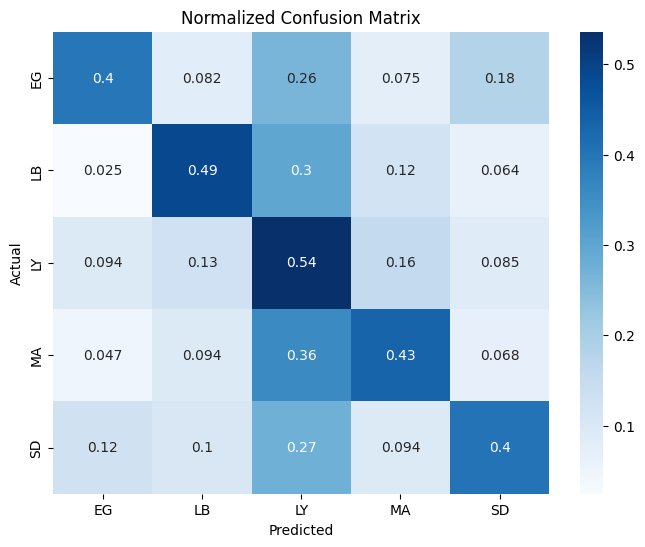

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
y_pred = np.argmax(model.predict(test_seq_pad), axis=1)
normalized_cm = confusion_matrix(y_test_encoded, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# `As conclusion, Classical ML is better in this problem than Deep Learning Models, So as a next step we will search a better model than Logistic Regression 🚀`

## ==================== Final Model Part =====================

## 1- Multinominal Naive-Bayes :

In [5]:
# To solve imbalancing data
#################################################################################
total_weight = sum(class_weight.values())                                       #
class_prior = [class_weight[i] / total_weight for i in range(len(class_weight))]#
#################################################################################
class_prior

[0.0732372635172225,
 0.15284226412218757,
 0.11565111762442588,
 0.3658213610134992,
 0.29244799372266495]

In [ ]:
mnb = MultinomialNB(class_prior=class_prior)
tfidf_vectorizer = TfidfVectorizer(max_features=200000)

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', tfidf_vectorizer),
    ('model', mnb)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', TfidfVectorizer(max_features=200000)),
                ('model',
                 MultinomialNB(class_prior=[0.0732372635172225,
                                            0.15284226412218757,
                                            0.11565111762442588,
                                            0.3658213610134992,
                                            0.29244799372266495]))])

In [ ]:
y_pred = pipeline.predict(X_val)
report = classification_report(y_val, y_pred)

print(report)

              precision    recall  f1-score   support

          EG       0.89      0.85      0.87      5763
          LB       0.86      0.87      0.87      2761
          LY       0.88      0.75      0.81      3650
          MA       0.56      0.78      0.65      1154
          SD       0.60      0.73      0.66      1444

    accuracy                           0.81     14772
   macro avg       0.76      0.80      0.77     14772
weighted avg       0.83      0.81      0.82     14772



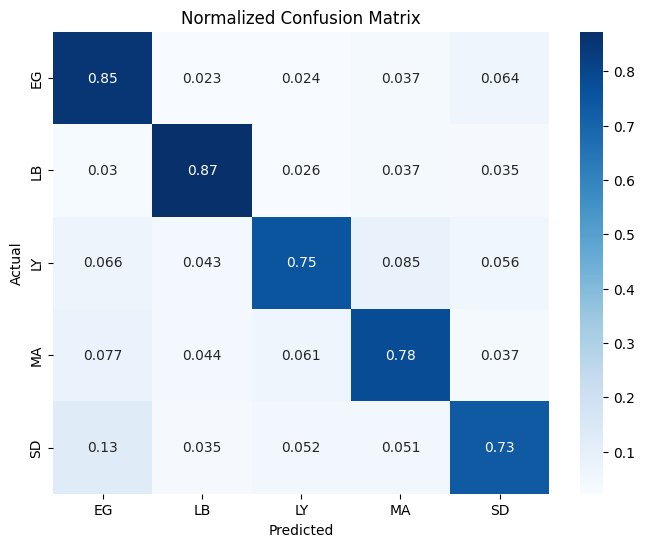

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

## 2- Logistic Regression :

In [ ]:
class_weight_lr = {'EG': 0.5126114207638423,
                 'LB': 1.0697927039015118,
                 'LY': 0.8094797767046816,
                 'MA': 2.560502654100314,
                 'SD': 2.0469385987702435}

In [ ]:
lr = LogisticRegression(class_weight=class_weight_lr, max_iter=10000, C=3)

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', tfidf_vectorizer),
    ('model', lr),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', TfidfVectorizer(max_features=200000)),
                ('model',
                 LogisticRegression(C=3,
                                    class_weight={'EG': 0.5126114207638423,
                                                  'LB': 1.0697927039015118,
                                                  'LY': 0.8094797767046816,
                                                  'MA': 2.560502654100314,
                                                  'SD': 2.0469385987702435},
                                    max_iter=10000))])

In [ ]:
y_pred = pipeline.predict(X_val)
report = classification_report(y_val, y_pred)

print(report)

              precision    recall  f1-score   support

          EG       0.90      0.87      0.88      5763
          LB       0.84      0.85      0.85      2761
          LY       0.81      0.82      0.82      3650
          MA       0.73      0.77      0.75      1154
          SD       0.70      0.73      0.71      1444

    accuracy                           0.83     14772
   macro avg       0.80      0.81      0.80     14772
weighted avg       0.83      0.83      0.83     14772



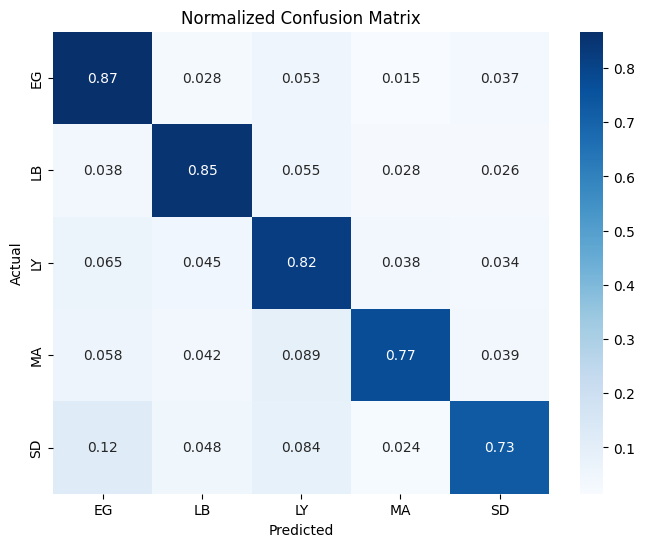

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Approximately Linear-Regression is slightly better than Multi-nominal Naive Bayes

# `Create Voter Classifier : `

In [ ]:
lr = LogisticRegression(class_weight=class_weight, max_iter=10000, C=3)
mnb = MultinomialNB(class_prior=class_prior)
voting_clf = VotingClassifier(estimators=[('lr', lr), ('mnb', mnb)], voting='soft')

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', tfidf_vectorizer),
    ('voter', voting_clf),
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', TfidfVectorizer(max_features=200000)),
                ('voter',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=3,
                                                                  class_weight={0: 0.5126114207638423,
                                                                                1: 1.0697927039015118,
                                                                                2: 0.8094797767046816,
                                                                                3: 2.560502654100314,
                                                                                4: 2.0469385987702435},
                                                                  max_iter=10000)),
                                              ('mnb',
                                               MultinomialNB(class_prior=[0.0732372635172225,
                                                                          0.15284226412218757,
                                                                          0.11565111762442588,
                                                                          0.3658213610134992,
                                                                          0.29244799372266495]))],
                                  voting='soft'))])

In [ ]:
y_pred = pipeline.predict(X_val)
report = classification_report(y_val, y_pred)

print(report)

              precision    recall  f1-score   support

          EG       0.90      0.88      0.89      5763
          LB       0.85      0.87      0.86      2761
          LY       0.85      0.81      0.83      3650
          MA       0.70      0.78      0.74      1154
          SD       0.69      0.74      0.72      1444

    accuracy                           0.84     14772
   macro avg       0.80      0.82      0.81     14772
weighted avg       0.84      0.84      0.84     14772



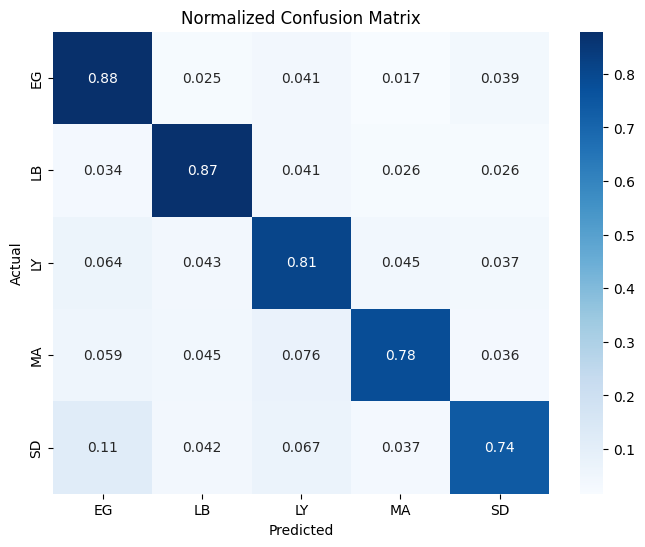

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

## Final Testing :

In [ ]:
y_pred_final = loaded_pipeline.predict(X_test)
report = classification_report(y_test, y_pred_final)
print(report)

              precision    recall  f1-score   support

          EG       0.90      0.88      0.89      5764
          LB       0.85      0.88      0.87      2762
          LY       0.84      0.81      0.82      3650
          MA       0.70      0.78      0.74      1154
          SD       0.69      0.73      0.71      1443

    accuracy                           0.84     14773
   macro avg       0.80      0.81      0.80     14773
weighted avg       0.84      0.84      0.84     14773



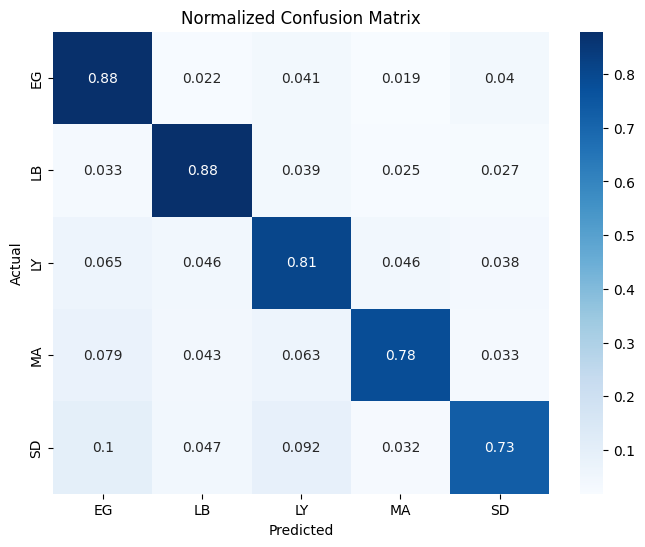

In [ ]:
target_labels = ['EG', 'LB', 'LY', 'MA', 'SD']
normalized_cm = confusion_matrix(y_test, y_pred_final, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Good improvment ✅



# Train to Whole Dataset and, Finaaaaaaallllyyyy save ⚡

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=250000)
lr = LogisticRegression(class_weight=class_weight, max_iter=10000, C=3)
mnb = MultinomialNB(class_prior=class_prior)
voting_clf = VotingClassifier(estimators=[('lr', lr), ('mnb', mnb)], voting='soft')

pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('Vectorizing', tfidf_vectorizer),
    ('voter', voting_clf),
])
pipeline.fit(df['text'], df['dialect'])


Pipeline(steps=[('preprocessing', CustomTransformer()),
                ('Vectorizing', TfidfVectorizer(max_features=250000)),
                ('voter',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=3,
                                                                  class_weight={0: 0.5126114207638423,
                                                                                1: 1.0697927039015118,
                                                                                2: 0.8094797767046816,
                                                                                3: 2.560502654100314,
                                                                                4: 2.0469385987702435},
                                                                  max_iter=10000)),
                                              ('mnb',
                                               MultinomialNB(class_prior=[0.0732372635172225,
                                                                          0.15284226412218757,
                                                                          0.11565111762442588,
                                                                          0.3658213610134992,
                                                                          0.29244799372266495]))],
                                  voting='soft'))])

In [7]:
import joblib
joblib.dump(pipeline, 'voting_pipeline_new.pkl')

# Load it to check it is properly saved ✅
loaded_pipeline = joblib.load('voting_pipeline_new.pkl')



## ============================ The End ===============================